In [2]:
#!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23909 sha256=a7f64420662590d87414d75c94cd14952dd5483894eeb75cf25c70e1e2e5f7bc
  Stored in directory: c:\users\luka.radovanovic\appdata\local\pip\cache\wheels\ec\cc\c1\32da8ee853d742d5d7cbd11ee04421222eb354672020b57297
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8368 sha256=66040508e0892e239a83977593425397d5f2a871dd69d84a5f799ace3d37ffb2
  Stored in directory: c:\users\luka.radovanovic\appdata\local\pip\cache\wheels\57\6d\a3\a39b839cc75274d2acfb1c58bfead2f726c6577fe8c4723f13
Successfully built yfinance multitasking


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn
import warnings
warnings.filterwarnings("ignore")

# yahoo finance is used to fetch data
import yfinance as yf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [5]:
#Reading the data for the past 13 years.
df = yf.download('GLD','2008-01-01','2021-10-11',auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [6]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2007-12-31,82.739998,82.830002,81.980003,82.459999,3815600
2008-01-02,83.559998,85.139999,83.440002,84.860001,12291100
2008-01-03,84.870003,85.940002,84.599998,85.570000,9553900
2008-01-04,85.339996,85.550003,84.430000,85.129997,8402200
2008-01-07,85.239998,85.260002,84.570000,84.769997,6944300


In [7]:
#We only need the closing Price .
df = df[['Close']]

In [8]:
df.isna().sum()

Close    0
dtype: int64

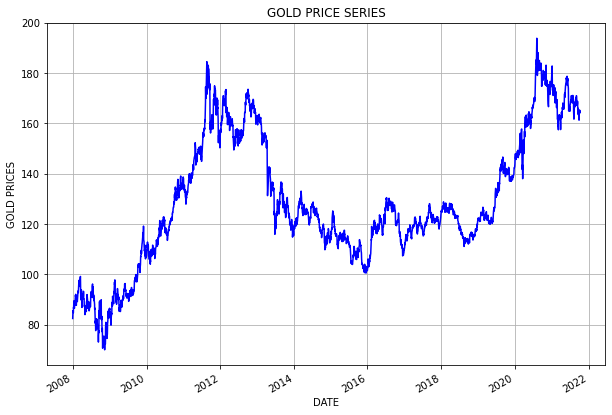

In [9]:


#Plot the closing price of GLD

df['Close'].plot(figsize=(10,7),color='b',grid=True)
plt.xlabel('DATE')
plt.ylabel("GOLD PRICES")
plt.title("GOLD PRICE SERIES")
plt.show()



In [11]:
#Defining the explanatory variables
# Finding moving average of past 3 days and 9 days

df['3_Days'] = df['Close'].shift(1).rolling(window=3).mean()
df['9_Days'] = df['Close'].shift(1).rolling(window=9).mean()



In [12]:


#Checking for null values
df.isna().sum()



Close     0
3_Days    3
9_Days    9
dtype: int64

In [13]:
# dropping the null data

df= df.dropna()

In [14]:
X= df[['3_Days','9_Days']]
X.head()

,3_Days,9_Days
Date,,
2008-01-14,87.793335,85.883333
2008-01-15,88.790001,86.670000
2008-01-16,88.703334,87.017777
2008-01-17,88.076665,87.143333
2008-01-18,87.063332,87.295555


In [15]:
#Defining the target variable

y= df['Close']
y.head()

Date
2008-01-14    89.540001
2008-01-15    87.989998
2008-01-16    86.699997
2008-01-17    86.500000
2008-01-18    87.419998
Name: Close, dtype: float64

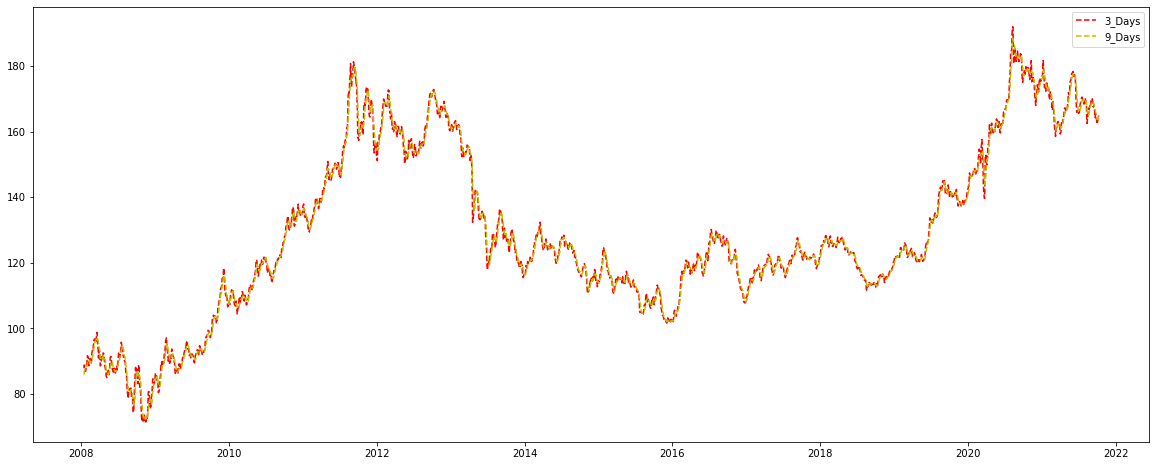

In [19]:


plt.figure(figsize=(20,8))
plt.plot(df['3_Days'],ls='--',color='r',) 
plt.plot( df["9_Days"] , ls='--',color ='y')
plt.legend(['3_Days', '9_Days'])




In [35]:
#Splitting  the data into train and test dataset

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle=False)

In [21]:


# Creating  a linear regression model

from sklearn.linear_model import LinearRegression
linear = LinearRegression().fit(X_train, y_train)


print("---------Linear Regression model------------")

print("Gold  Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (c)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))



---------Linear Regression model------------
Gold  Price (y) = 1.20 * 3 Days Moving Average (x1) + -0.21 * 9 Days Moving Average (x2) + 0.44 (c)


In [22]:
# Predicting the Gold  prices based on the test dataset 

pre_price = linear.predict(X_test)
pre_price = pd.DataFrame(pre_price, index=y_test.index, columns=['price'])

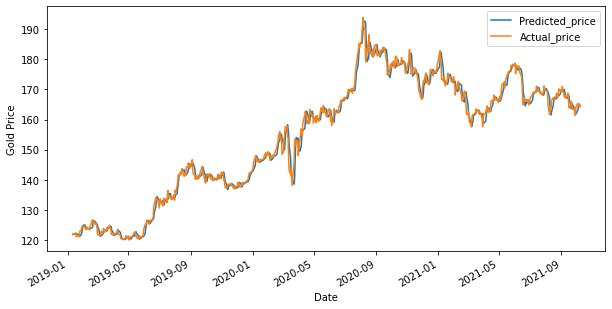

In [23]:
#Visualizing the predicted dataset with the test dataset 

pre_price.plot(figsize=(10, 5),)
y_test.plot()

plt.legend(['Predicted_price', 'Actual_price'])
plt.ylabel("Gold Price")
plt.show()

In [24]:
# Model Evaluation 
#Calculating the r square and mse.

r2_score = linear.score(X_test, y_test)*100

print("R square for regression is ", float("{0:.2f}".format(r2_score)))
np.sqrt(mean_squared_error(y_test,pre_price))

R square for regression is  98.91


2.0528715293309205

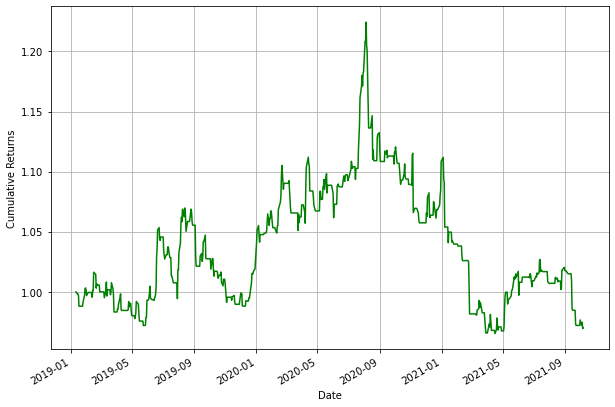

In [25]:
#Plotting the Cummalitve returns to analyse its performance

#comparing predicted price of today with next day for further direction.
gold = pd.DataFrame()
t=int(0.8*len(df)) 
gold['price'] = df[t:]['Close']
gold['predicted_price_next_day'] = pre_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)


gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)
gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g',grid=True)
plt.ylabel('Cumulative Returns')
plt.show()

In [26]:
#to predict the gold prices and give a position
# whether one should buy GLD or take no position.

df1 = yf.download('GLD', '2008-06-01', '2021-3-09', auto_adjust=True)
df1['3_Day'] = df1['Close'].rolling(window=3).mean()
df1['9_Day'] = df1['Close'].rolling(window=9).mean()
df1 = df1.dropna()

df1['predicted_gold_price'] = linear.predict(df1[['3_Day', '9_Day']])
df1['Position'] = np.where(df1.predicted_gold_price.shift(1) < df1.predicted_gold_price,"Buy","No Position")
df1.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,3_Day,9_Day,predicted_gold_price,Position
Date,,,,,,,,,
2008-06-12,85.190002,86.070000,84.830002,85.599998,9826200,86.056666,87.017776,85.999993,No Position
2008-06-13,85.330002,86.019997,85.040001,85.830002,8429000,86.149999,86.781110,86.161008,Buy
2008-06-16,88.199997,88.199997,86.970001,87.010002,6993700,86.146667,86.795555,86.154025,No Position
2008-06-17,86.720001,87.519997,86.699997,87.250000,5285800,86.696668,86.862222,86.801731,Buy
2008-06-18,87.660004,88.410004,87.129997,88.279999,7818800,87.513334,87.065555,87.741973,Buy
2008-06-19,89.370003,89.500000,88.389999,88.419998,10520500,87.983332,86.994444,88.321860,Buy
2008-06-20,88.820000,89.610001,88.769997,88.949997,10057800,88.549998,87.101111,88.981365,Buy
2008-06-23,87.010002,87.400002,86.739998,87.089996,12784300,88.153330,87.272221,88.469062,No Position
2008-06-24,87.300003,88.239998,87.239998,87.470001,7398500,87.836665,87.322222,88.077927,No Position


In [27]:
from pmdarima import auto_arima

In [28]:
model=auto_arima(y=y_train,exogenous=X_train,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=9667.227, Time=3.97 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10722.872, Time=0.94 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9667.357, Time=2.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9915.571, Time=3.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10727.116, Time=0.75 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=9656.958, Time=3.50 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=9652.356, Time=2.80 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=9654.319, Time=3.58 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=9664.672, Time=2.91 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=9662.757, Time=0.80 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9654.320, Time=1.31 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 26.402 seconds


In [30]:
arima_pre=model.predict(n_periods=len(X_test),exogenous=X_test)

C:\Users\luka.radovanovic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [36]:
arima_pred_price = pd.DataFrame(arima_pre, index=y_test.index, columns=['price'])

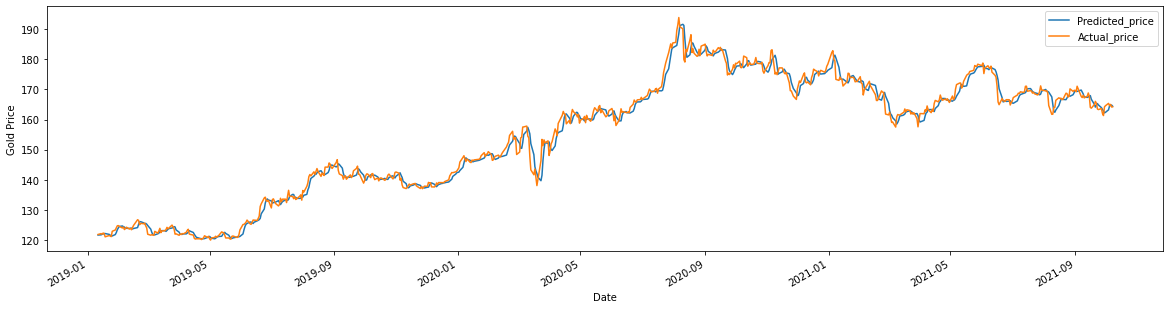

In [38]:
#Visualizing the predicted dataset with the test dataset 

arima_pred_price.plot(figsize=(20, 5),)
y_test.plot()

plt.legend(['Predicted_price', 'Actual_price'])
plt.ylabel("Gold Price")
plt.show()

In [39]:
# Model Evaluation 
#Calculating the r square and mse.

r2_score = linear.score(X_test, y_test)*100

print("R square for regression is ", float("{0:.2f}".format(r2_score)))
np.sqrt(mean_squared_error(y_test,arima_pred_price))

R square for regression is  98.91


2.056887940979392